# Exploratory Data Analysis of Triage Data

In this notebook we wish to inspect the time series data of patients, and try to predict their triage level. This is part of the CodeVsCovid19 Hackathon. Our goal here is to find a model which is best suited to aid doctors, when 

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score

import matplotlib.pyplot as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
DATA_PATH = "../data_simulator/data_new/"

patient_df = pd.read_csv(DATA_PATH + "patients_list.csv", index_col=0)
measurement_df = pd.read_csv(DATA_PATH + "measurements.csv",index_col=0)

In [3]:
display(patient_df.head())
display(measurement_df.head())
print(patient_df.shape, measurement_df.shape)

,patientID,name,surname,phone,city,language,age,preconditions,fitness,smoker,clinician,clinicianID,organization,organizationID,under_observation
0,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,Julie,Smith,+44191 4960525,Marctown,German,63,None,7,False,['Dr. Michelle Morris'],['2eb58c31-28d9-477c-a2c7-f09eb27ca7c2'],['center_9'],['091f0e81-2892-42e7-975d-b2b82aebb4b3'],False
1,bda43cdc-96cb-4ea2-b49e-74042dd0759f,Ashleigh,Singh,(0116) 496 0597,West Iainshire,Dutch,66,None,2,False,['Dr. Deborah Jackson'],['19f45222-2576-4564-85ea-a623a2066ec1'],['center_2'],['983a3902-26da-4f2e-ba32-d98935a979d6'],False
2,0080bb10-7a8a-404f-ad50-304c24085d9a,Gail,Davis,+441184960821,Hodgsonport,German,94,None,1,False,['Dr. Helen Nelson'],['8177e1ae-047d-41a5-ab25-3b140c0cf83c'],['center_8'],['fb796cf7-279b-46db-8c91-3acc37b7de40'],False
3,6202cfa4-8856-41c6-a49d-93fbe8d44e15,Owen,Green,(01632) 960 524,Fishermouth,Italian,90,None,1,False,"['Dr. Thomas Edwards', 'Dr. Lawrence Tucker']","['1be9c155-47d7-436b-999c-9e49b1e0d8cb', 'f3f5...","['center_6', 'center_0']","['28425030-5bbc-471c-9f62-b6d3c2ec0b79', '1b44...",False
4,85302e0d-4404-4b9d-9772-2b3c70513a07,Victor,Barker,+44306 9990474,Millsport,French,75,Arthritis,0,False,['Dr. Hilary Taylor'],['49e542ab-92ae-4bca-86f7-72cd502c034f'],['center_3'],['1a82f7ad-7d57-44f2-9d93-c336c7e69fa3'],True


,patientID,timestamp,heart_beat,oxygenation,temperature,breathing_rate,triage_level
0,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,2020-03-23 11:35:12,147,95,37.3,14,1
1,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,2020-03-23 19:35:12,149,91,37.3,14,1
2,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,2020-03-24 03:35:12,140,92,36.5,14,1
3,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,2020-03-24 11:35:12,146,96,36.5,15,1
4,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,2020-03-24 19:35:12,142,94,36.9,12,1


(5000, 15) (103683, 7)


In [4]:
# Merge the two data sets
df = pd.merge(patient_df, measurement_df, on="patientID", how="inner")

In [5]:
print(df.shape)
df["timestamp"] = pd.to_datetime(df['timestamp'])
df.head()

(103683, 21)


,patientID,name,surname,phone,city,language,age,preconditions,fitness,smoker,clinician,clinicianID,organization,organizationID,under_observation,timestamp,heart_beat,oxygenation,temperature,breathing_rate,triage_level
0,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,Julie,Smith,+44191 4960525,Marctown,German,63,None,7,False,['Dr. Michelle Morris'],['2eb58c31-28d9-477c-a2c7-f09eb27ca7c2'],['center_9'],['091f0e81-2892-42e7-975d-b2b82aebb4b3'],False,2020-03-23 11:35:12,147,95,37.3,14,1
1,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,Julie,Smith,+44191 4960525,Marctown,German,63,None,7,False,['Dr. Michelle Morris'],['2eb58c31-28d9-477c-a2c7-f09eb27ca7c2'],['center_9'],['091f0e81-2892-42e7-975d-b2b82aebb4b3'],False,2020-03-23 19:35:12,149,91,37.3,14,1
2,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,Julie,Smith,+44191 4960525,Marctown,German,63,None,7,False,['Dr. Michelle Morris'],['2eb58c31-28d9-477c-a2c7-f09eb27ca7c2'],['center_9'],['091f0e81-2892-42e7-975d-b2b82aebb4b3'],False,2020-03-24 03:35:12,140,92,36.5,14,1
3,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,Julie,Smith,+44191 4960525,Marctown,German,63,None,7,False,['Dr. Michelle Morris'],['2eb58c31-28d9-477c-a2c7-f09eb27ca7c2'],['center_9'],['091f0e81-2892-42e7-975d-b2b82aebb4b3'],False,2020-03-24 11:35:12,146,96,36.5,15,1
4,09e6fb7f-9b57-4eb6-b1cb-de721e60889c,Julie,Smith,+44191 4960525,Marctown,German,63,None,7,False,['Dr. Michelle Morris'],['2eb58c31-28d9-477c-a2c7-f09eb27ca7c2'],['center_9'],['091f0e81-2892-42e7-975d-b2b82aebb4b3'],False,2020-03-24 19:35:12,142,94,36.9,12,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103683 entries, 0 to 103682
Data columns (total 21 columns):
patientID            103683 non-null object
name                 103683 non-null object
surname              103683 non-null object
phone                103683 non-null object
city                 103683 non-null object
language             103683 non-null object
age                  103683 non-null int64
preconditions        103683 non-null object
fitness              103683 non-null int64
smoker               103683 non-null bool
clinician            103683 non-null object
clinicianID          103683 non-null object
organization         103683 non-null object
organizationID       103683 non-null object
under_observation    103683 non-null bool
timestamp            103683 non-null datetime64[ns]
heart_beat           103683 non-null int64
oxygenation          103683 non-null int64
temperature          103683 non-null float64
breathing_rate       103683 non-null int64
triage_le

In [7]:
df.describe()

,age,fitness,heart_beat,oxygenation,temperature,breathing_rate,triage_level
count,103683.000000,103683.000000,103683.000000,103683.000000,103683.000000,103683.000000,103683.000000
mean,58.733881,4.557710,105.505020,88.716627,37.643466,17.834418,2.014303
std,27.731150,2.857342,31.280313,8.004887,1.146145,4.789764,1.423295
min,10.000000,0.000000,60.000000,75.000000,36.500000,12.000000,1.000000
25%,35.000000,2.000000,78.000000,79.000000,36.900000,14.000000,1.000000
50%,60.000000,5.000000,96.000000,91.000000,37.200000,17.000000,1.000000
75%,83.000000,7.000000,142.000000,95.000000,38.000000,19.000000,3.000000
max,106.000000,9.000000,149.000000,99.000000,41.000000,29.000000,5.000000


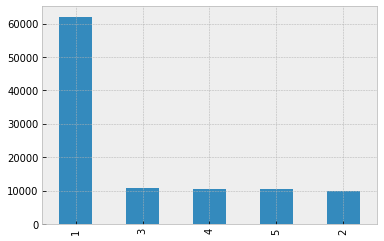

In [8]:
from sklearn.utils import class_weight
display(df["triage_level"].value_counts().plot.bar())

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df["triage_level"]),
                                                 df["triage_level"])

class_weights = dict(zip(range(1,6),class_weights))

## Inspect some examples
As a first step we wish to inspect some time series examples of some random patients.

In [9]:
random_patients = patient_df["patientID"].sample(4).values.tolist()

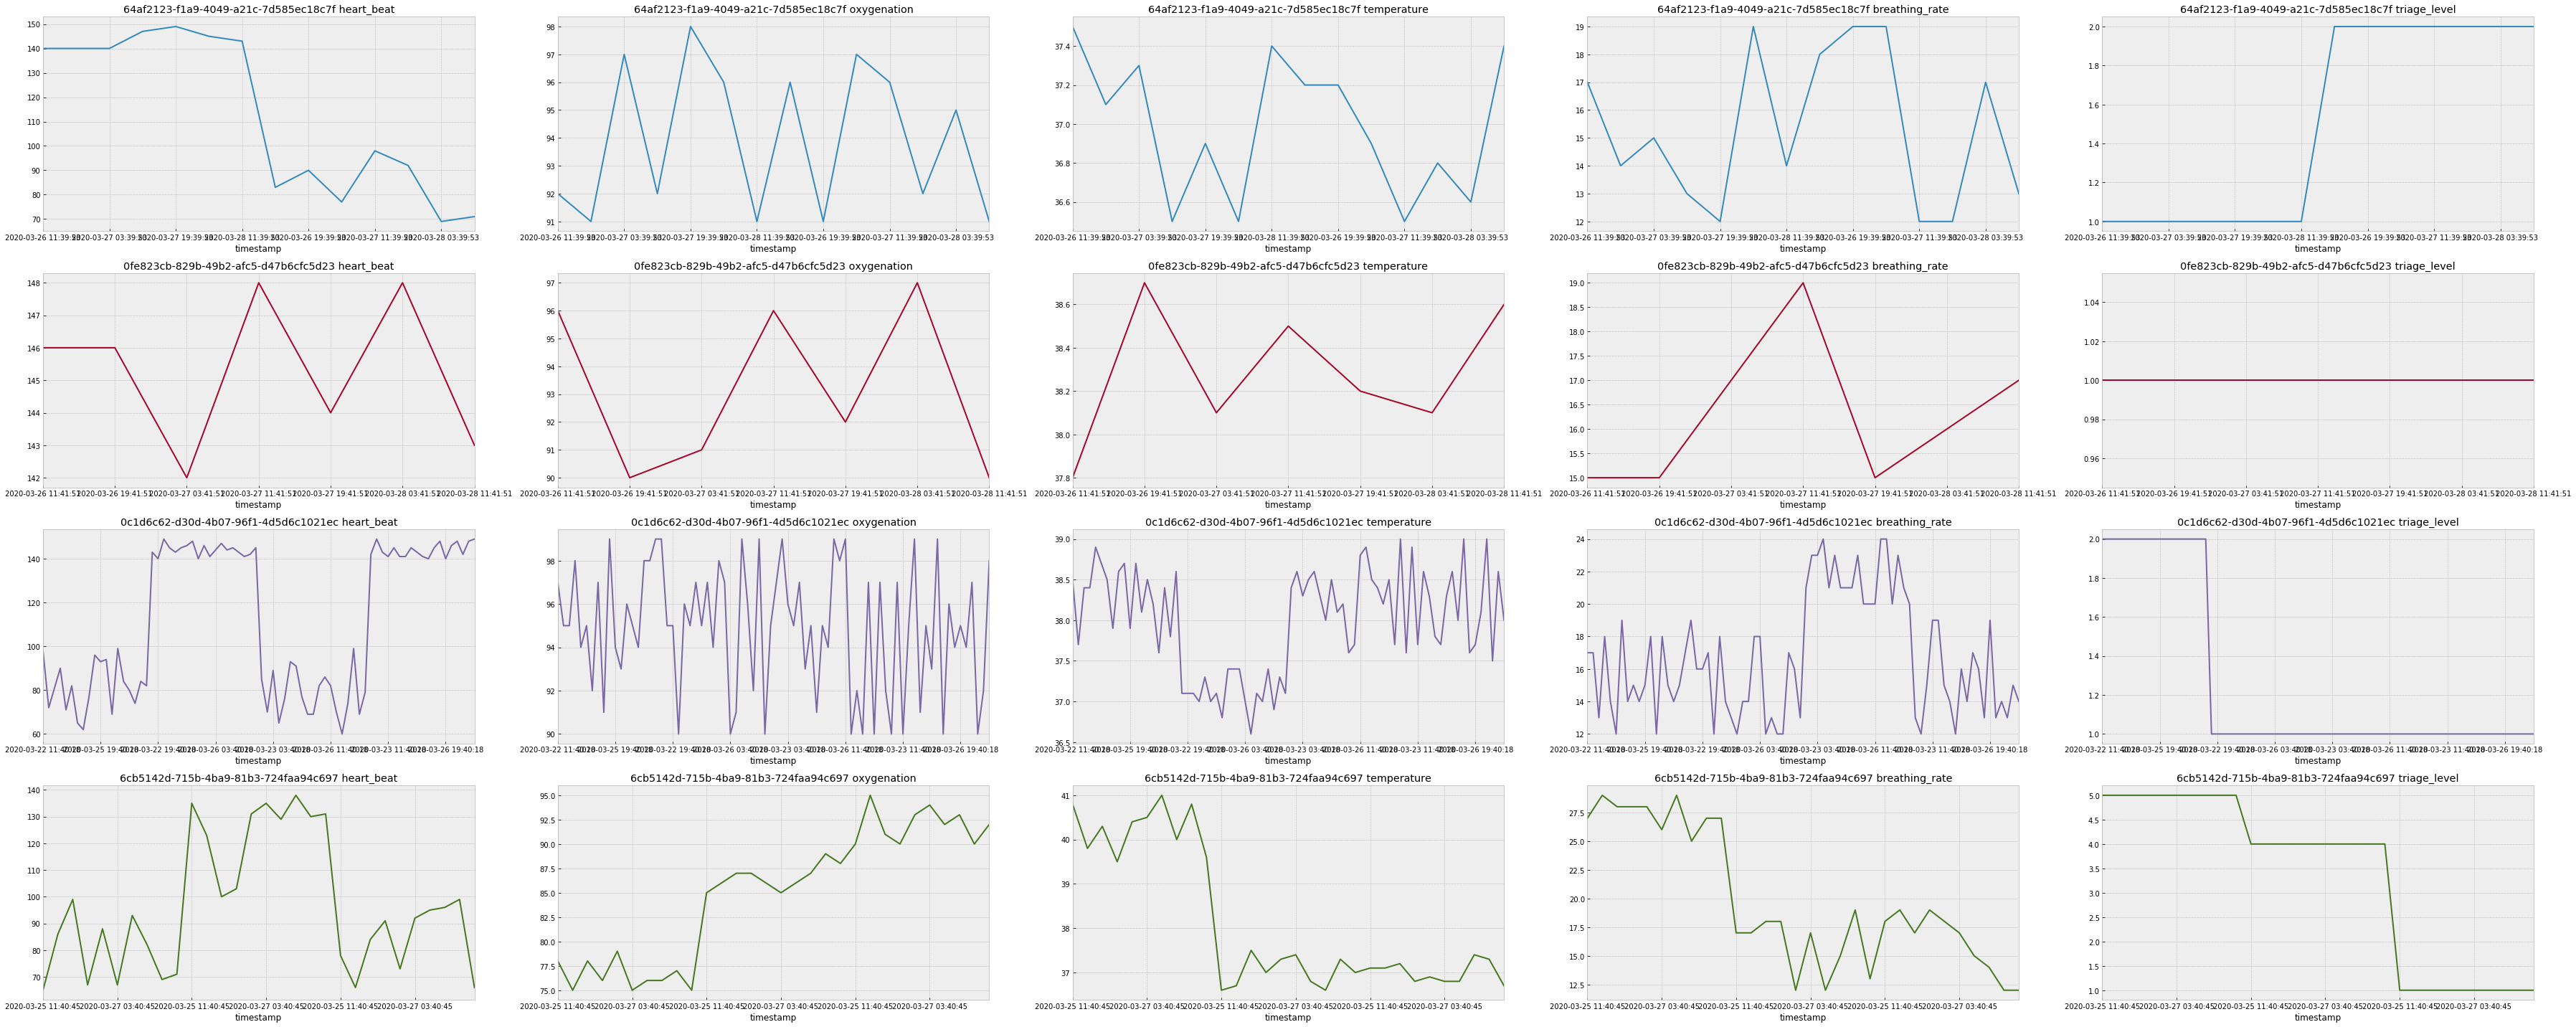

In [10]:
TIME_COLUMNS = ["heart_beat", "oxygenation", "temperature", "breathing_rate", "triage_level"]

fig, axs = plt.subplots(4, 5, figsize=(50,20))
axs = axs.flatten()
ax_idx = 0

for patient in random_patients:
    example_data = measurement_df.loc[measurement_df["patientID"] == patient].set_index("timestamp")
    color = next(color_cycle)
    for col in TIME_COLUMNS:
        example_data[col].plot(title= patient + " "+ col,
                               color=color,
                              ax=axs[ax_idx])
        ax_idx += 1
    
plt.tight_layout()
plt.show()

## Data Preparation
To successfully train a model, we need to split our data into train and test set. Furthermore, we might need to create additional features.

Initially, we just want to use the measured data and the medical data of each patient.

In [11]:
TRAIN_COLUMNS = TIME_COLUMNS + ["preconditions", "fitness","smoker"]
clean_df = df.dropna()

X = clean_df[TRAIN_COLUMNS].drop("triage_level", axis=1)
X = pd.get_dummies(X,prefix=['preconditions'])

y = clean_df["triage_level"]

In [12]:
from sklearn.model_selection import train_test_split as tts, cross_val_score
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, shuffle=True)

In [13]:
model = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42, class_weight=class_weights)

scores = cross_val_score(model, X_train, y_train, cv = 4, scoring="f1_macro")
print("Mean Cross Validation Score: ", scores.mean())
print("Standard Deviation of Cross Validation Score: ", scores.std())

Mean Cross Validation Score:  0.6174997298415383
Standard Deviation of Cross Validation Score:  0.003950354453769323


In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Test Score: ", f1_score(y_val, y_pred, average="macro"))

Test Score:  0.629704275226971


## Feature Importance

Let's have look which are the most important features

In [15]:
def show_feature_importance(forest):
    """
    Creates a sorted list of the feature importance of a random forest algorithm.
    Furthermore it plots it.
    params:
        forest: RandomForestRegressor algorithm
    """
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("{}, Feature: {}, Importance: {}".format(f + 1, X.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(20,10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]),  X.columns[indices], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
1, Feature: temperature, Importance: 0.22219852048978594
2, Feature: heart_beat, Importance: 0.20003541509053474
3, Feature: breathing_rate, Importance: 0.1825577953976295
4, Feature: oxygenation, Importance: 0.17019204748630762
5, Feature: fitness, Importance: 0.1567125587527342
6, Feature: smoker, Importance: 0.02120028228396946
7, Feature: preconditions_None, Importance: 0.013156161635533199
8, Feature: preconditions_Hypertension, Importance: 0.012805078256346384
9, Feature: preconditions_Arthritis, Importance: 0.011010144569657604
10, Feature: preconditions_Asthma, Importance: 0.007771106166671739
11, Feature: preconditions_Cancer, Importance: 0.002360889870829635


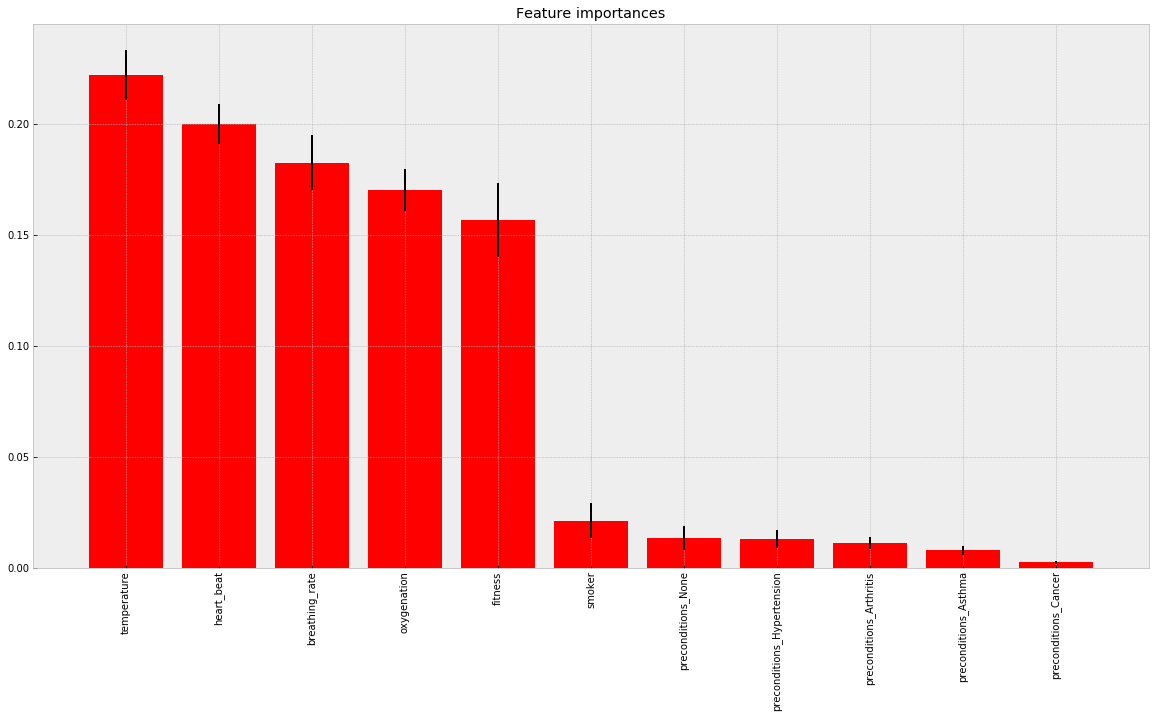

In [16]:
show_feature_importance(model)

## Save our model
now we want to save our model into a pickle file, such that we can later import it in a python backend file.

In [17]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))